# Sentiment Analysis

## Pre-processing

In [1]:
!python --version
import torch
print(torch.__version__)

Python 3.10.12
2.1.0+cu118


In [2]:
!pip install torchtext==0.6.0 --quiet
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.9 MB/s eta 0:00:00
2023-12-11 21:00:04.886564: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 21:00:04.893682: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 21:00:04.893750: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 21:00:04.918803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the fo

In [3]:
import random

SEED = 2337
random.seed(SEED)

import numpy as np
import pandas as pd
import spacy

from sklearn.metrics import accuracy_score
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import  f1_score

from torch import nn
import torch
from torchtext import data
from torch.nn  import functional as F
import torch.optim as  optim
if torch.cuda.is_available():
  dev = "cuda:0"
  print("gpu up")
else:
  dev = "cpu"
device = torch.device(dev)

gpu up


### Clean data: tokenization, converting to lower case etc

In [4]:

import nltk
nltk.download("punkt")

import re
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

tokenizer = Tokenizer(nlp.vocab)

from nltk import word_tokenize,sent_tokenize
from nltk.stem  import PorterStemmer


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
stops = stopwords.words("english")


def removepunc(my_str): # function to remove punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct

def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
snowstem = SnowballStemmer("english")
portstem = PorterStemmer()
def myTokenizer(x):
 return  [snowstem.stem(word.text)for word in
          tokenizer(removepunc(re.sub(r"\s+\s+"," ",re.sub(r"[^A-Za-z0-9()!?\'\`\"\r+\n+]"," ",x.lower()))).strip())
          if (word.text not in stops and not hasNumbers(word.text)) ]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
data_tmp = pd.read_csv("imdb.csv",nrows=20000)
def transform_label(label):
    return 1 if label == 'positive' else 0

data_tmp['label'] = data_tmp['sentiment'].apply(transform_label)
data_tmp.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [7]:
traindata = data_tmp.sample(frac=0.8, random_state=123)  # 80% for training
test = data_tmp.drop(traindata.index)

traindata.drop("sentiment",axis=1,inplace=True)
test.drop("sentiment",axis=1,inplace=True)
traindata.head()

,review,label
12136,"I enjoyed this one, because I can relate to it...",1
16812,If it were possible to award a 10+ .... this w...,1
10072,The inspiring story of Carl Brashear (Cuba Goo...,1
5850,You could have put the characters on the islan...,0
4320,This film has to be one of the most boring fil...,0


In [8]:
TEXT = data.Field(tokenize=myTokenizer,batch_first=True,fix_length=140)
LABEL = data.LabelField(dtype=torch.float ,batch_first=True)


class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('review', text_field), ('label', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row.label
            text = row.review
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)


torchdataset = DataFrameDataset(traindata, TEXT,LABEL)
torchtest = DataFrameDataset(test, TEXT,LABEL)

In [9]:
train_data, valid_data = torchdataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [10]:
"""
this cell build the vocab which means it get all the used words and if also ignores any word
that only appeared less than 3 times
"""
TEXT.build_vocab(train_data,min_freq=3)
LABEL.build_vocab(train_data)


#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))



#set batch size
BATCH_SIZE = 128

"""
we are using batches for validation and test set because of memory usage we can't pass the whole set at once
"""


train_iterator,valid_iterator,test_iterator= data.BucketIterator.splits(
    (train_data,valid_data,torchtest),
    batch_size = BATCH_SIZE,
    device = device,
    sort =False,
shuffle=False)

Size of TEXT vocabulary: 19290
Size of LABEL vocabulary: 2
[('br', 52473), ('movi', 26455), ('film', 24455), ('one', 14287), ('like', 11524), ('time', 8183), ('good', 7817), ('make', 7740), ('get', 7226), ('charact', 7133)]


## Build Model

By the construction, we have a text data of length maximum 140, with padded zero at the end if maximum is not reached. In this section, I will build the transformer used for the text data

### Split batch size

### 1. Transformer simple

In [11]:
#set batch size
BATCH_SIZE = 128


"""
we are using batches for validation for efficiency
"""
torch.manual_seed(2337)
train_iterator,valid_iterator,test_iterator= data.BucketIterator.splits(
    (train_data,valid_data,torchtest),
    batch_size = BATCH_SIZE,
    device = device,
    sort =False,
shuffle=True)

In [16]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term) #for odd using sin: sin (pos*exp(-log(10000)*2i/d) ) = sin(pos/ (10000^{2i/d}))
        pe[:, 1::2] = torch.cos(position * div_term)
        #If you have parameters in your model, which should be saved and restored in the state_dict, but not trained by the optimizer,
        #you should register them as buffers.
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


#embedding size is just d as explained in project written work
class TextTransformer(nn.Module):
  def __init__(self, embedding_size=140,num_heads=7, hidden_size1=64, hidden_size2=16):
    super(TextTransformer,self).__init__()
    self.embedding_size = embedding_size
    self.wordEmbeddings = nn.Embedding(len(TEXT.vocab),embedding_size)
    self.positional_encoding = PositionalEncoding(embedding_size, 140)
    self.transformerLayer = nn.TransformerEncoderLayer(embedding_size,num_heads)
    self.linear1 = nn.Linear(embedding_size,  hidden_size1)
    self.linear2 = nn.Linear(hidden_size1,  1)
    self.linear3 = nn.Linear(embedding_size,  hidden_size2)
    self.linear4 = nn.Linear(hidden_size2,  1)
    self.relu = nn.ReLU()
  def forward(self,x):
    #positions = (torch.arange(0,140).reshape(1,140) + torch.zeros(x.shape[0],140)).to(device)
    # broadcasting the tensor of positions
    sentence = self.positional_encoding(self.wordEmbeddings(x))
    attended = self.transformerLayer(sentence)
    linear1 = self.relu(self.linear1(attended))
    linear2 = self.relu(self.linear2(linear1))
    # reshaping the layer as the transformer outputs a 2d tensor (or otherwise 3d considering the batch size)
    linear2 = linear2.view(-1,self.embedding_size)
    linear3 = self.relu(self.linear3(linear2))
    out = torch.sigmoid(self.linear4(linear3))
    return out

myTransformer = TextTransformer()
myTransformer.to(device)

TextTransformer(
  (wordEmbeddings): Embedding(19290, 140)
  (positional_encoding): PositionalEncoding()
  (transformerLayer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=140, out_features=140, bias=True)
    )
    (linear1): Linear(in_features=140, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=140, bias=True)
    (norm1): LayerNorm((140,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((140,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (linear1): Linear(in_features=140, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
  (linear3): Linear(in_features=140, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [17]:
#define metrics for eval
def calculateMetrics(ypred,ytrue):
  acc  = accuracy_score(ytrue,ypred)
  auc  = roc_auc_score(ytrue,ypred)
  f1_average  = f1_score(ytrue,ypred,average="macro")
  return " auc score: "+str(round(auc,3))+" f1 average: "+str(round(f1_average,3))+" accuracy: "+str(round(acc,3))

In [18]:

# evaluation
#import time

#start = time.time()

"""
using adagrad because it assign bigger updates to less frequently updated weights
(like words that are not used many times)

"""
loss_func = torch.nn.BCELoss()
learning_rate = 0.05
epoch = 50
train_error=[]
val_error=[]

optimizer = optim.SGD(myTransformer.parameters(),lr = learning_rate)
#optimizer = optim.Adam(myTransformer.parameters(),lr = 1)

for i in range(epoch):
  trainpreds = torch.tensor([])
  traintrues = torch.tensor([])
  for batch in train_iterator:
    X = batch.review
    y = batch.label
    myTransformer.train()
    optimizer.zero_grad() #gradient need to be reupdate to 0 each epoch
    pred = myTransformer(X).squeeze() #resize
    trainpreds = torch.cat((trainpreds,pred.cpu().detach())) #detach from device
    traintrues = torch.cat((traintrues,y.cpu().detach()))
    err = loss_func(pred,y)
    err.backward() #backward propagation
    optimizer.step()
  with torch.inference_mode():
    err = loss_func(trainpreds,traintrues)
    train_error.append(err)
    print("train BCE loss: ",err.item(),calculateMetrics(torch.round(trainpreds).numpy(),traintrues.numpy()))


  valpreds = torch.tensor([])
  valtrues = torch.tensor([])
  for batch in valid_iterator:
    X = batch.review
    y = batch.label
    valtrues = torch.cat((valtrues,y.cpu().detach()))
    pred = myTransformer(X).squeeze().cpu().detach()
    # print(valtrues.shape)
    valpreds = torch.cat((valpreds,pred))
  with torch.inference_mode():
    err = loss_func(valpreds,valtrues)
    val_error.append(err)
    print("train BCE loss: ",err.item(),calculateMetrics(torch.round(valpreds).numpy(),valtrues.numpy()))

#end = time.time()

#print("Time difference for running 50 iteration requires: ",end-start)

train BCE loss:  0.6944503784179688  auc score: 0.494 f1 average: 0.477 accuracy: 0.491
train BCE loss:  0.693306028842926  auc score: 0.505 f1 average: 0.452 accuracy: 0.506
train BCE loss:  0.6931111216545105  auc score: 0.505 f1 average: 0.491 accuracy: 0.508
train BCE loss:  0.6930757164955139  auc score: 0.511 f1 average: 0.51 accuracy: 0.511
train BCE loss:  0.692628026008606  auc score: 0.508 f1 average: 0.488 accuracy: 0.511
train BCE loss:  0.6930953860282898  auc score: 0.509 f1 average: 0.457 accuracy: 0.508
train BCE loss:  0.6921600103378296  auc score: 0.513 f1 average: 0.451 accuracy: 0.518
train BCE loss:  0.6925364136695862  auc score: 0.515 f1 average: 0.513 accuracy: 0.515
train BCE loss:  0.6916326880455017  auc score: 0.52 f1 average: 0.491 accuracy: 0.524
train BCE loss:  0.6924114227294922  auc score: 0.525 f1 average: 0.502 accuracy: 0.524
train BCE loss:  0.6908165216445923  auc score: 0.525 f1 average: 0.483 accuracy: 0.529
train BCE loss:  0.6915885210037231 

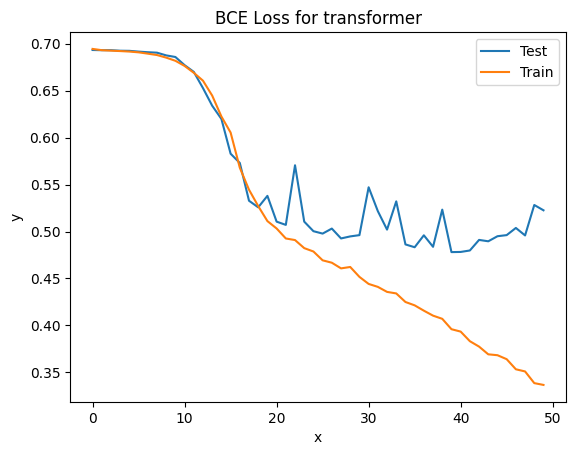

In [19]:
loss_array_transformer = [val_error[i].numpy().astype('float64') for i in range(len(val_error))]
train_error_array_transformer= [train_error[i].numpy().astype('float64') for i in range(len(train_error))]
import matplotlib.pyplot as plt


plt.plot(loss_array_transformer, label='Test')
plt.plot(train_error_array_transformer, label='Train')
plt.title('BCE Loss for transformer')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()